In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
import shap
import umap.umap_ as umap

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.impute import SimpleImputer

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

file_path = os.path.join("data","processed_data.csv")

df = pd.read_csv(file_path)  

X = df.drop(columns=['Class', 'WsRF', 'Latency', 'Best Practices', 'Response Time']) 
Y = df['Class']

# Define baseline

In [3]:

baseline_model = LogisticRegression(random_state=42)

scalers=[StandardScaler(), MinMaxScaler()]

for scaler in scalers:
    
    print(f'=== Scaller: {scaler}====')
    X_scalled = scaler.fit_transform(X)
    
    X_rest, X_test, Y_rest, Y_test = train_test_split(X_scalled,Y, test_size=0.15, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42)

    baseline_model.fit(X_train, Y_train)

    # 4. Predict on test set
    y_pred = baseline_model.predict(X_val)

    # 5. Evaluate performance
    print("Baseline Accuracy:", accuracy_score(Y_val, y_pred))
    print("\nClassification Report:\n", classification_report(Y_val, y_pred))


=== Scaller: StandardScaler()====
Baseline Accuracy: 0.9354838709677419

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.89      0.94         9
           2       0.94      0.89      0.92        19
           3       0.83      1.00      0.91        15
           4       1.00      0.95      0.97        19

    accuracy                           0.94        62
   macro avg       0.94      0.93      0.94        62
weighted avg       0.94      0.94      0.94        62

=== Scaller: MinMaxScaler()====
Baseline Accuracy: 0.9193548387096774

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.89      0.94         9
           2       0.89      0.89      0.89        19
           3       0.83      1.00      0.91        15
           4       1.00      0.89      0.94        19

    accuracy                           0.92        62
   macro avg       0.93      0.92      0.92    

StandardScaler gives better accuracy

- feature importance in baseline model

ExactExplainer explainer: 310it [00:14, 20.11it/s]                         


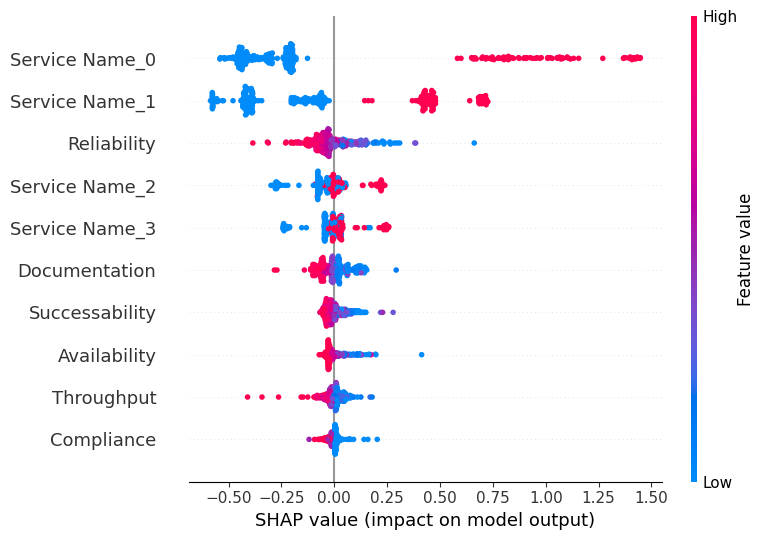

In [4]:
scalers=StandardScaler()
X_scalled = scaler.fit_transform(X)
X_scalled=pd.DataFrame(X_scalled, columns = X.columns)

X_rest, X_test, Y_rest, Y_test = train_test_split(X_scalled,Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42)

baseline_model.fit(X_rest,Y_rest)
explainer = shap.Explainer(baseline_model.predict, X_rest)  
shap_values = explainer(X_rest)

shap.summary_plot(shap_values, X_rest)

Removing Response Time, Best Pratices and Latency can reduce overfitting risk; Improve model interpretability; Speed up training and inference.

[0.00647249 0.01100324 0.00550162 0.0184466  0.00485437 0.00873786
 0.14854369 0.32006472 0.1038835  0.05533981]


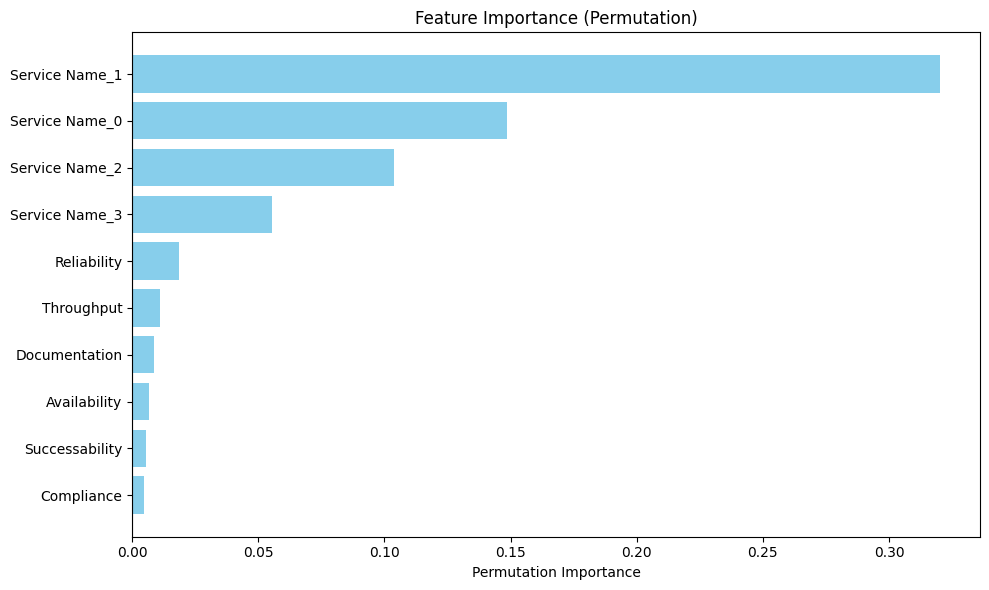

In [5]:
result = permutation_importance(baseline_model, X_rest, Y_rest, n_repeats=10, random_state=42)
print(result.importances_mean)


# Feature names and importance values
importances = result.importances_mean
features = X_rest.columns

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df_sorted = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

High permutation importance might come from interactions or leakage rather than true explanatory power.
Keeping them could lead to overfitting, especially if they represent identifiers rather than meaningful attributes.

- With dimensionality reduction

In [6]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scalled)

X_rest, X_test, Y_rest, Y_test = train_test_split(X_umap,Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.2, random_state=42)

baseline_model.fit(X_train, Y_train)

# 4. Predict on test set
y_pred = baseline_model.predict(X_val)

# 5. Evaluate performance
print("Baseline Accuracy:", accuracy_score(Y_val, y_pred))
print("\nClassification Report:\n", classification_report(Y_val, y_pred))

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Baseline Accuracy: 0.5967741935483871

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.78      0.88         9
           2       0.53      0.53      0.53        19
           3       0.53      0.60      0.56        15
           4       0.58      0.58      0.58        19

    accuracy                           0.60        62
   macro avg       0.66      0.62      0.64        62
weighted avg       0.61      0.60      0.60        62



# RandomizedSearchCV

In [7]:
models = {
    'lr': LogisticRegression(max_iter=1000, random_state=42),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(max_depth=2, random_state=42),
    'nb': GaussianNB(),
    'svm': svm.SVC(probability=True),
    'knc': KNeighborsClassifier(n_neighbors=3),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, probability=True)
}

param_grids = {
    'lr': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    },
    'dt': {
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'rf': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'svm': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'knc': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'xgb': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

k_folds = KFold(n_splits=5)
model_scores = {}


In [8]:

k_folds = KFold(n_splits = 5)

model_scores={}

for name, model in models.items():
    if name in param_grids:
        
        if name =='xgb':
            Y_rest = Y_rest - 1
            
        search = RandomizedSearchCV(model, param_grids[name], cv=k_folds, scoring='accuracy', n_jobs=-1)
        search.fit(X_rest if name in ['lr', 'svm', 'knc'] else X_rest, Y_rest)
        best_score = search.best_score_
        best_model = search.best_estimator_
        print(f"{name}: Best Score={best_score:.4f}, Best Params={search.best_params_}")
    else:
        scores = cross_val_score(model, X_rest, Y_rest, cv=k_folds, scoring='accuracy')
        best_score = scores.mean()
        best_model = model.fit(X_rest, Y_rest)
        print(f"{name}: Score={best_score:.4f}")
    
    model_scores[name] = (best_score, best_model)

# Select best model
best_model_name = max(model_scores, key=lambda k: model_scores[k][0])

if best_model_name != 'xbg' : 
    Y_rest = Y_rest + 1

best_model = model_scores[best_model_name][1]
print(f"\nBest model: {best_model_name} with score {model_scores[best_model_name][0]:.4f}")



c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


lr: Best Score=0.6572, Best Params={'solver': 'liblinear', 'C': 10}
dt: Best Score=0.8899, Best Params={'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
rf: Best Score=0.9094, Best Params={'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
nb: Score=0.7314
svm: Best Score=0.9159, Best Params={'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
knc: Best Score=0.9094, Best Params={'weights': 'uniform', 'n_neighbors': 3}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


xgb: Best Score=0.8998, Best Params={'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

Best model: svm with score 0.9159


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:45:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "probability", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
best_model.fit(X_rest, Y_rest)

y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)

print('Best Model ', best_model_name)
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print(classification_report(Y_test, y_pred))

Best Model  svm
Test Accuracy: 0.9091
              precision    recall  f1-score   support

           1       1.00      0.78      0.88         9
           2       0.83      0.94      0.88        16
           3       0.88      0.93      0.90        15
           4       1.00      0.93      0.97        15

    accuracy                           0.91        55
   macro avg       0.93      0.90      0.91        55
weighted avg       0.92      0.91      0.91        55



In [10]:
def plot_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)  # [1, 2, 3, 4]

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [11]:
def plot_roc_curve(y_true, y_score):
    classes = np.unique(y_true)  # [1, 2, 3, 4]

    plt.figure(figsize=(6, 5))
    
    for idx, cls in enumerate(classes):
        
        fpr, tpr, _ = roc_curve(y_true == cls, y_score[:, idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [12]:
def plot_precision_recall(y_true, y_score):

    classes = np.unique(y_true)  # [1, 2, 3, 4]
    
    plt.figure(figsize=(6, 5))

    for idx, cls in enumerate(classes):  # idx = 0..3, cls = 1..4
    
        precision, recall, _ = precision_recall_curve(y_true == cls, y_score[:, idx])
        plt.plot(recall, precision, label=f'Class {cls}')
    
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [13]:
def plot_class_accuracy(y_true, y_pred):
    classes = np.unique(y_true)  # [1, 2, 3, 4]
    
    accuracies = []
    for cls in classes:
        cls_idx = (y_true == cls)
        acc = np.mean(y_pred[cls_idx] == cls)
        accuracies.append(acc)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=classes, y=accuracies)
    plt.title('Class-wise Accuracy')
    plt.ylabel('Accuracy')


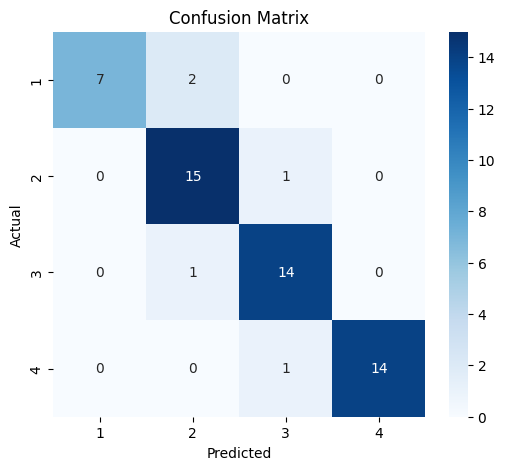

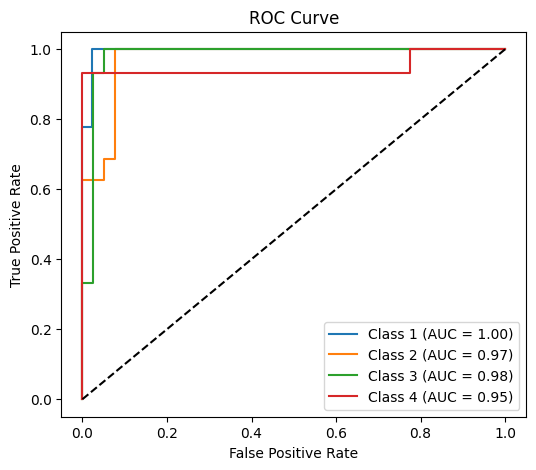

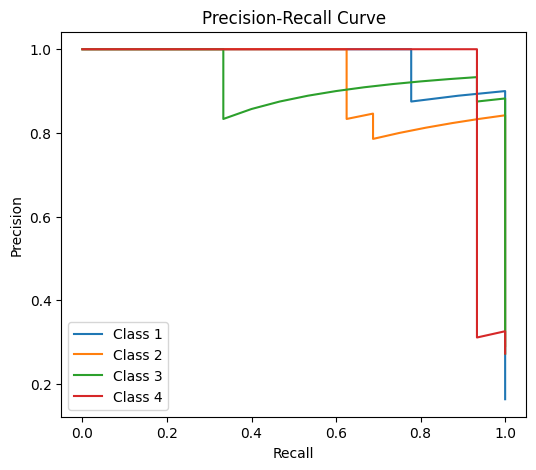

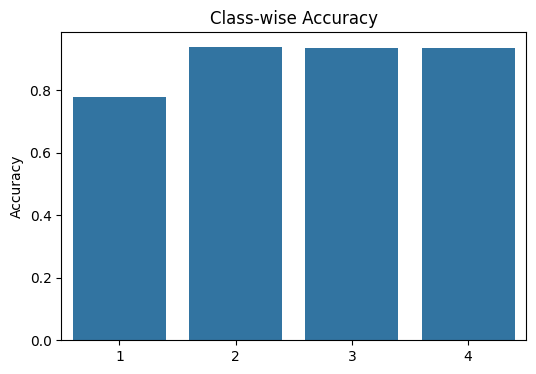

In [14]:
plot_confusion_matrix(Y_test, y_pred)
plot_roc_curve(Y_test, y_score)
plot_precision_recall(Y_test, y_score)
plot_class_accuracy(Y_test, y_pred)

In [16]:
numeric_features = ['Availability', 'Throughput', 'Successability',
                    'Reliability', 'Compliance', 'Best Practices', 'Documentation']
categorical_features = ['Service Name']


def winsorize(X):
    df_num = pd.DataFrame(X, columns=numeric_features)
    for col in numeric_features:
        if df_num[col].notna().sum() > 0: 
            lower = df_num[col].quantile(0.25)
            upper = df_num[col].quantile(0.75)
            df_num[col] = np.clip(df_num[col], lower, upper)
    return df_num

winsorizer = FunctionTransformer(winsorize, validate=False)

numeric_transformer = Pipeline(steps=[
    ("winsorizer", winsorizer),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", BinaryEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder='drop')  

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)  
])


def save_model_package(base_path, model_name, pipeline, metrics, feature_names, data_info,
                       X_train=None, X_test=None, y_train=None, y_test=None):
    """
    Saves:
    - Model
    - Metrics (JSON + CSV)
    - Model Card
    - Splits (optional)
    """
    path = os.path.join(base_path, model_name)
    os.makedirs(path, exist_ok=True)

    # Save model
    joblib.dump(pipeline, os.path.join(path, 'pipeline_model.pkl'))

    # Save metrics
    with open(os.path.join(path, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    pd.DataFrame([metrics]).to_csv(os.path.join(path, 'metrics.csv'), index=False)

    # Create model card
    with open(os.path.join(path, 'model_card.md'), 'w') as f:
        f.write(f"""
            # Model Card: {model_name}

            ## Data
            Source: {data_info.get('source')}
            Size: {data_info.get('size')}

            ## Features
            {', '.join(feature_names)}

            ## Metrics
            {json.dumps(metrics, indent=4)}
            """)

    # Save splits if provided
    if X_rest is not None and X_test is not None:
        joblib.dump(X_rest, os.path.join(path, 'X_rest.pkl'))
        joblib.dump(X_test, os.path.join(path, 'X_test.pkl'))
    if Y_rest is not None and y_test is not None:
        joblib.dump(Y_rest, os.path.join(path, 'y_rest.pkl'))
        joblib.dump(y_test, os.path.join(path, 'y_test.pkl'))

    print(f"Model package saved at: {path}")

# Metrics
metrics = {
    "accuracy": accuracy_score(Y_test, y_pred),
    "precision": precision_score(Y_test, y_pred, average='weighted'),
    "recall": recall_score(Y_test, y_pred, average='weighted'),
    "f1_score": f1_score(Y_test, y_pred, average='weighted')
}

# Info for model card
data_info = {"source": "qws1/data.csv", "size": len(df)}
feature_names = numeric_features + categorical_features

# Save everything
save_model_package('classification_package', 'best_model', pipeline, metrics, feature_names, data_info,
                   X_train=X_rest, X_test=X_test, y_train=Y_rest, y_test=Y_test)

Model package saved at: classification_package\best_model
